This notebook shows you how to create Marking Maps from tracking data. If you're not interested in the code or you're not familiar with the concept, you can read [this blog post](https://medium.com/football-crunching/introducing-marking-maps-b37951e77bb1).

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


import sys, os
sys.path.insert(0, os.path.abspath('../scripts/'))
import footyviz

plt.style.use('ggplot')
pd.set_option('mode.chained_assignment',None)

# The Data

For this notebook, I used Period 1 of [Metrica’s Sample Match 1](https://github.com/metrica-sports/sample-data/tree/master/data/Sample_Game_1).


In [2]:
DATA_DIR = '../../sample-data/data/Sample_Game_1/' #point to where you downloaded metrica's sample data to
dfEvents = pd.read_csv(DATA_DIR+'Sample_Game_1_RawEventsData.csv')
dfAway = pd.read_csv(DATA_DIR+'Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
dfHome = pd.read_csv(DATA_DIR+'Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)

def get_pos_meters(df, x='x', y='y'):
    return df[[x, y]]*np.array([105/100, 68/100])

def get_pos_vis(df, x='x', y='y'):
    return df[[x, y]]*np.array([100/105, 100/68])

def add_mark_pos(df, target, t=5):
    if t:
        df['x_future'] = df['x']+df['dx']*t
        df['y_future'] = df['y']+df['dy']*t
    else:
        df['x_future'] = df['x']
        df['y_future'] = df['y']

    dist = target-df[['x_future', 'y_future']]
    
    df[['x_mark', 'y_mark']] = df[['x_future', 'y_future']]+dist.values/np.linalg.norm(dist.values, axis=1, keepdims=True)*2
    return df

def convert_df(df, target):
    columns = df.columns[3:]
    players = columns[::2]
    other = columns[1::2]

    x = df.set_index(['Period', 'Frame', 'Time [s]'])[players]
    y = df.set_index(['Period', 'Frame', 'Time [s]'])[other]
    y.columns = players

    dfConverted = pd.concat([x.stack(),y.stack()], axis=1)*100
    dfConverted.columns = ['x', 'y']

    dfConverted = add_mark_pos(get_pos_meters(dfConverted), target, t=0)

    return dfConverted.reset_index().rename(columns={'level_3': 'player'})

def proccess_df(df, edge, bg, team):
    df = df.set_index('Frame')
    df[['x','y']] =  get_pos_vis(df)
    df['edgecolor'] = edge
    df['bgcolor'] = bg
    df['team'] = team
    df['player'] = df.player.replace({'Ball':0})
    df['player_id'] = df.player.str.replace('Player', '')
    return df
    

dfAway = convert_df(dfAway, np.array([5.5/1.05,50]))
dfHome = convert_df(dfHome,  np.array([100-5.5/1.05,50]))
dfFull = pd.concat([proccess_df(dfHome, 'white', 'red', 'attack'),
                    proccess_df(dfAway[dfAway.player!='Ball'], 'white', 'blue', 'defense'),
                   ])

dfAway.head()

,Period,Frame,Time [s],player,x,y,x_future,y_future,x_mark,y_mark
0,1,1,0.04,Player25,95.03445,32.27416,95.03445,32.27416,93.072314,32.661487
1,1,1,0.04,Player15,61.31265,14.13992,61.31265,14.13992,59.627730,15.217438
2,1,1,0.04,Player16,71.04090,31.76280,71.04090,31.76280,69.113552,32.296963
3,1,1,0.04,Player17,70.67550,52.00368,70.67550,52.00368,68.676437,51.942469
4,1,1,0.04,Player18,42.82215,41.83700,42.82215,41.83700,40.867717,42.261490


# Defining Marking

The marking relationships were calculated as follows:

1. Calculate the ideal position for marking each attacking player (defined as two meters from the attacker towards the goal)

2. Take a defender, and then:
* Calculate the distance from the defender to each attacker’s marking position.
* Filter to the minimum distance.
* If that distance is above a threshold (I used 7.5m), then assume the defender isn’t marking anyone.

3. Loop through all defenders (so, one defender can only be marking one attacker, but two defenders can be marking the same attacker).

4. If an attacker has no defender marking him, add a row to the table (with no marker).
There are a lot of things you can do to improve on this (e.g. consider momentum, prioritize free attackers, prioritize stable relationships). That may be a subject for a later post.

In [3]:
%%time
def get_marking_player(df_att, df_def, did, max_dist=2.5):
    df_def = df_def.loc[df_def.player==did].set_index('Frame')
    df_att = df_att.loc[df_att.player!='Ball']
    df_att = df_att.set_index('Frame').join(df_def.loc[:,['x','y']], rsuffix='_def')
    df_att.loc[:,'distance_to_def'] = np.linalg.norm(df_att[['x_mark', 'y_mark']].values-df_att[['x_def', 'y_def']].values, axis=1)
    df_min_dist = df_att.groupby('Frame')['distance_to_def'].transform(min)
    df_mark = df_att.loc[df_att.distance_to_def==df_min_dist]
    df_mark.loc[df_mark.distance_to_def>max_dist,'player'] = 'None'
    df_mark.loc[:,'defender'] = did
    return df_mark

def get_marking_all(df_att, df_def, max_dist=2.5):
    dfMark = pd.concat([get_marking_player(df_att, df_def, did, max_dist) for did in df_def.player.unique() if did!='Ball'])
    for player in df_att.player.unique():
        if player != 'Ball':
            total_frames = set(df_att.loc[df_att.player==player].set_index('Frame').index)
            new_frames = total_frames-set(dfMark.loc[dfMark.player==player].index)
            dfMark = dfMark.append(df_att.loc[df_att.player==player].set_index('Frame').loc[new_frames])
    dfMark.loc[:,'defender'].fillna('None', inplace=True)
    dfMark.loc[:,'percent'] = 1/len(df_att.Frame.unique())
    return dfMark

dfMark = get_marking_all(dfHome, dfAway, max_dist=10)

Wall time: 1min 25s


# Visualization

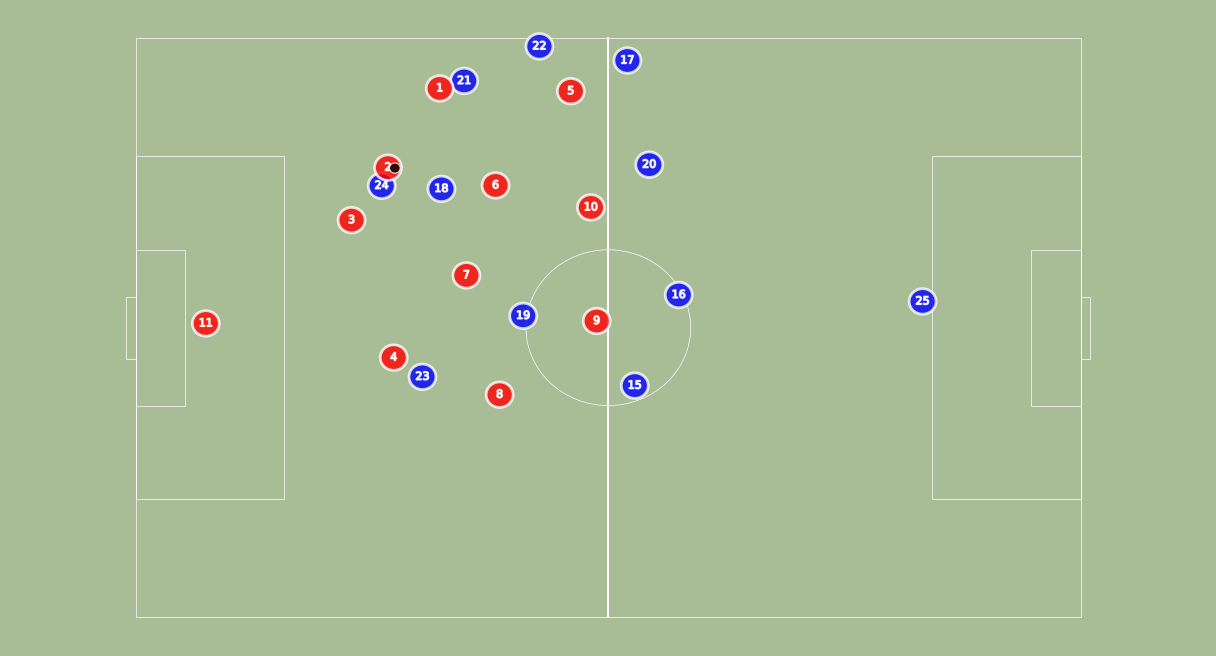

In [4]:
#basic viz
fig,ax,dfF = footyviz.draw_frame(dfFull, t=380/20, label='player_id')

## Red Team Attacking

In [5]:
%%time
dfEvents = dfEvents.loc[dfEvents.Period==1]
dfEvents.loc[:,'Possession_ID'] = (dfEvents['Team']!=dfEvents['Team'].shift()).cumsum()

dfPossessions = dfEvents.loc[dfEvents.Team=='Home'].groupby('Possession_ID').agg({'Start Frame': min,
                                                              'End Frame': max})

flatten = lambda l: [item for sublist in l for item in sublist]
PossFrames = flatten([range(x['Start Frame'],x['End Frame']) for i, x in dfPossessions.iterrows()])

dfHomePoss = dfHome.set_index('Frame').loc[PossFrames]
dfAwayPoss = dfAway.set_index('Frame').loc[PossFrames]

dfMarkPoss = get_marking_all(dfHomePoss.reset_index(), dfAwayPoss.reset_index(), max_dist=10)

Wall time: 14.4 s


In [6]:
%%time
def get_possession_dfs(att_team, dfHome, dfAway, dfEvents):
    '''
    att_team should be either `Home` or `Away`
    '''
    dfEvents['Possession_ID'] = (dfEvents['Team']!=dfEvents['Team'].shift()).cumsum()
    dfPossessions = dfEvents.loc[dfEvents.Team==att_team].groupby('Possession_ID').agg({'Start Frame': min,
                                                                  'End Frame': max})
    flatten = lambda l: [item for sublist in l for item in sublist]
    PossFrames = flatten([range(x['Start Frame'],x['End Frame']) for i, x in dfPossessions.iterrows()])
    dfHomePoss = dfHome.set_index('Frame').loc[PossFrames]
    dfAwayPoss = dfAway.set_index('Frame').loc[PossFrames]
    return dfHomePoss, dfAwayPoss

dfHomePoss, dfAwayPoss = get_possession_dfs('Away', dfHome, dfAway, dfEvents)
dfMarkPoss = get_marking_all(dfAwayPoss.reset_index(), dfHomePoss.reset_index(), max_dist=10)

Wall time: 12.8 s


In [7]:
def get_marking_table(dfMark):
    markings = dfMark.reset_index().pivot_table(values='percent',
                                                index='player',
                                                columns='defender',
                                                aggfunc='sum',
                                                margins=False,
                                                fill_value=0                                       
                                               ).rename_axis(index='attacker')

    return (markings*100).style.format('{0:,.0f}%').background_gradient(axis=None)

get_marking_table(dfMarkPoss)

defender,None,Player1,Player10,Player11,Player12,Player2,Player3,Player4,Player5,Player6,Player7,Player8,Player9
attacker,,,,,,,,,,,,,
None,0%,10%,10%,98%,4%,11%,10%,37%,10%,12%,9%,19%,2%
Player15,56%,0%,20%,0%,0%,0%,0%,0%,1%,1%,0%,15%,11%
Player16,57%,0%,17%,0%,0%,1%,0%,0%,2%,1%,0%,2%,22%
Player17,57%,1%,14%,0%,0%,0%,1%,2%,7%,1%,0%,7%,16%
Player18,44%,1%,1%,0%,1%,2%,1%,13%,4%,3%,7%,33%,2%
Player19,21%,4%,5%,0%,12%,2%,2%,9%,12%,21%,27%,13%,5%
Player20,34%,0%,23%,0%,1%,0%,0%,0%,5%,19%,3%,2%,34%
Player21,23%,12%,5%,0%,6%,3%,3%,4%,22%,24%,20%,4%,3%
Player22,54%,7%,4%,0%,1%,0%,0%,0%,31%,1%,5%,0%,3%


In [8]:
dfHomePoss, dfAwayPoss = get_possession_dfs('Away', dfHome, dfAway, dfEvents)
dfHomePoss = dfHomePoss.loc[dfHomePoss.player!='Player12']
dfMarkPoss = get_marking_all(dfAwayPoss.reset_index(), dfHomePoss.reset_index(), max_dist=7.5)

In [9]:
def draw_marking_map(dfMark, dfDef, dfAtt=None, att_color='red', def_color='blue', frame=None, min_percent=0.1, drop_ball=True):
    fig,ax = footyviz.draw_pitch()
    if dfAtt is None:
        dfAtt=dfMark
    if frame is None:
        dfPlayersDefense = get_pos_vis(dfDef.groupby('player')[['x','y']].mean())
        dfPlayersAttack = get_pos_vis(dfAtt.groupby('player')[['x','y']].mean())
    else:
        dfPlayersDefense = get_pos_vis(dfDef.loc[frame].set_index('player'))
        dfPlayersAttack = get_pos_vis(dfAtt.loc[frame].set_index('player'))
        dfMark = dfMark.loc[frame]
        min_percent = 0
    if drop_ball:
        dfPlayersDefense = dfPlayersDefense.drop('Ball')
        dfPlayersAttack = dfPlayersAttack.drop('Ball')
    else:
        dfPlayersDefense = dfPlayersDefense.rename({'Ball': 0})
        dfPlayersAttack = dfPlayersAttack.rename({'Ball': 0})

    dfPlayersDefense['edgecolor'] = 'white'
    dfPlayersDefense['bgcolor'] = def_color
    dfPlayersDefense['team'] = 'defense'
    dfPlayersDefense['player_id'] = dfPlayersDefense.index.str.replace('Player', '')
    footyviz.add_players(fig, ax, dfPlayersDefense, label='player_id')

    dfPlayersAttack['edgecolor'] = 'white'
    dfPlayersAttack['bgcolor'] = att_color
    dfPlayersAttack['team'] = 'attack'
    dfPlayersAttack['player_id'] = dfPlayersAttack.index.str.replace('Player', '')
    footyviz.add_players(fig, ax, dfPlayersAttack, label='player_id')

    markings_list = dfMark.groupby(['player', 'defender'])['percent'].sum().drop(
        'None', errors='ignore').drop('None', level=1, errors='ignore')
    markings_list = markings_list[markings_list>min_percent]

    for i, percent in markings_list.iteritems():
        linewidth = (percent*6)**2 if frame is None else 1
        attack_pos = dfPlayersAttack.loc[i[0]][['x','y']]
        defend_pos = dfPlayersDefense.loc[i[1]][['x','y']]
        ax.add_line(plt.Line2D((attack_pos['x'],defend_pos['x']),
                               (attack_pos['y'],defend_pos['y']),
                               c='dimgray', linewidth=linewidth,
                               zorder=20
                              ))

    plt.scatter(data=dfPlayersDefense.loc[set(markings_list.reset_index().defender)], x='x', y='y', s=600, c='dimgray', marker='o', zorder=20)
    
    direction = -1 if (dfAtt['x'].mean()-dfDef['x'].mean())>0 else 1
    arrowpros = {'width': 5, 'linewidth': '1', 'ec':'white', 'fc':att_color}
    ax.annotate('', xy=(50+10*direction, -5), xytext=(50-5*direction,-5), arrowprops=arrowpros)
    plt.text(45.5 if direction==1 else 42, -3.5, 'direction of play')

    leg_d_x = 50+30*direction
    leg_a_x = 50+25*direction
    df_legend = pd.DataFrame([[leg_d_x,-4,'D',def_color,'white', 'defense'],
                              [leg_a_x,-4,'A',att_color,'white', 'attack']],
                             columns=('x','y','player_id','bgcolor','edgecolor', 'team'),
                             index=(1,2)
                            )

    footyviz.add_players(fig, ax, df_legend, label='player_id')
    ax.add_line(plt.Line2D((leg_d_x,leg_a_x), (-4,-4),c='dimgray', linewidth=linewidth,zorder=20))
    plt.scatter(leg_d_x,-4,s=600, c='dimgray', marker='o', zorder=20)
    plt.autoscale(axis='y')
    fig.set_size_inches(12.8, 7.6)
    return fig, ax

The images below show a few random moments from the match. The marking relationships are shown as a line between the defender (with a circle around him) and the attacker:

(<Figure size 1280x760 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2c00250cf08>)

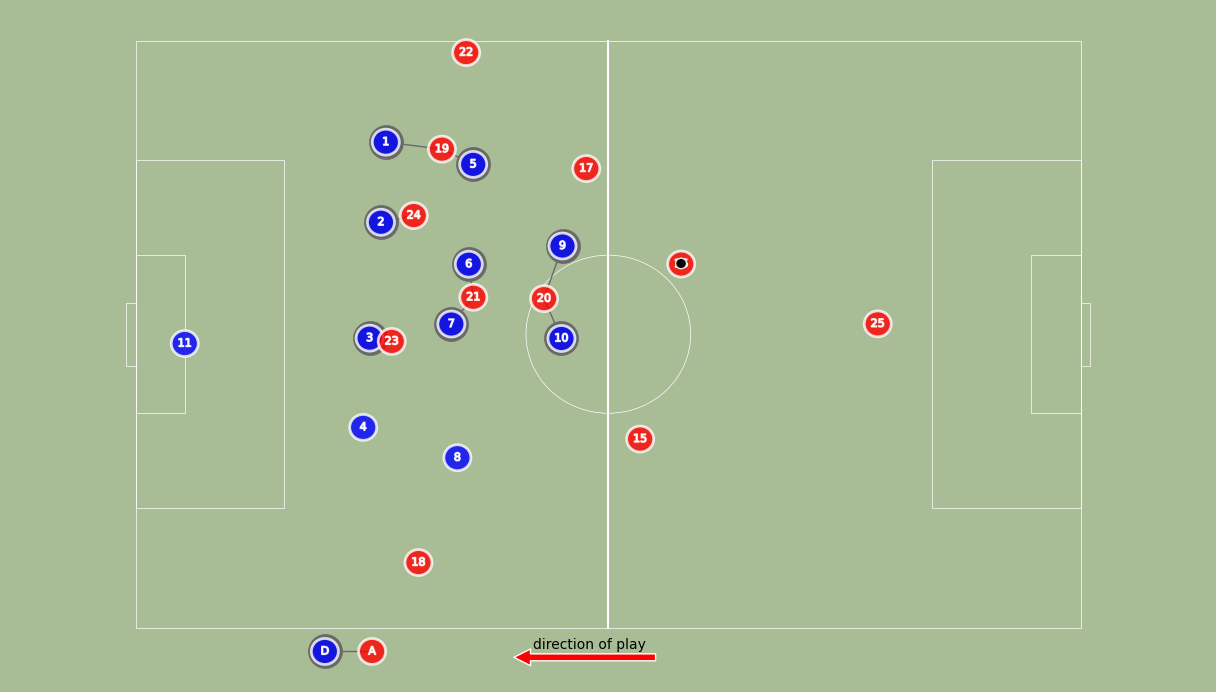

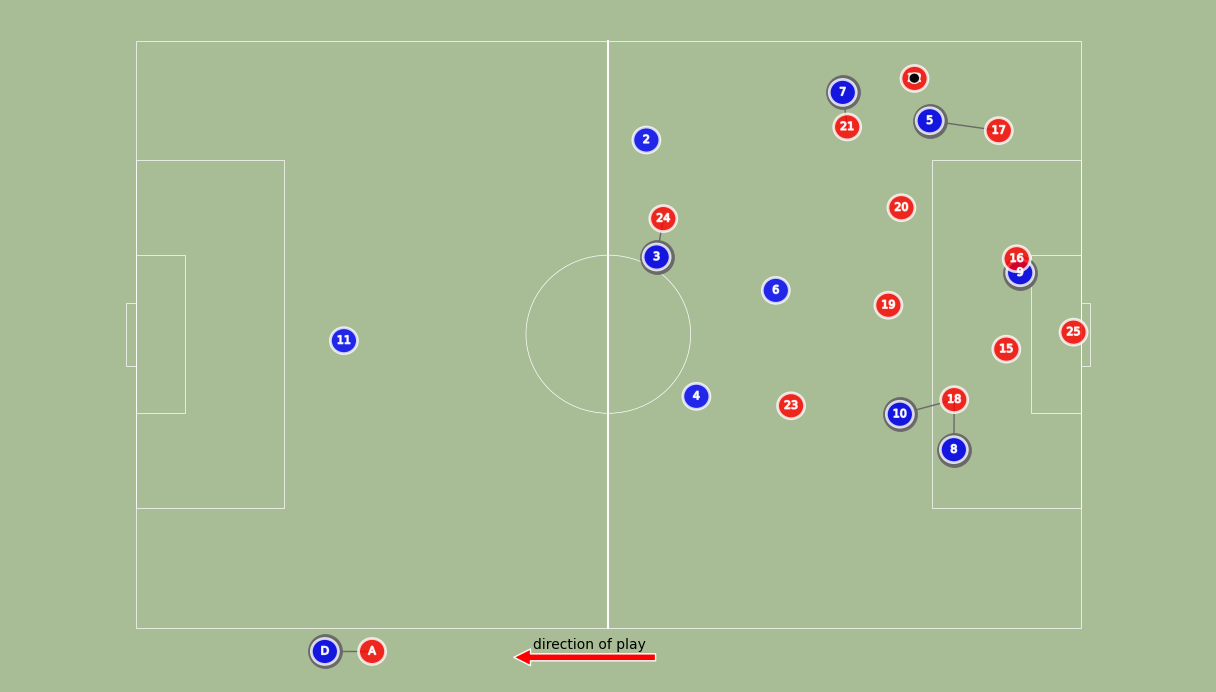

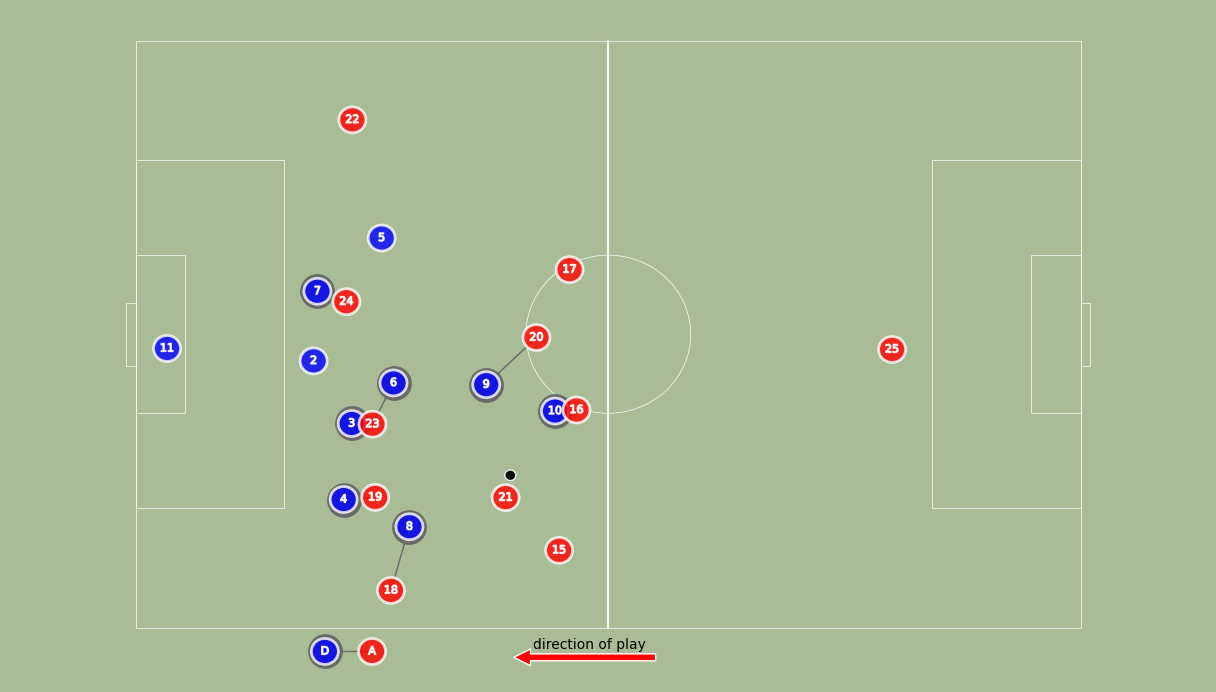

In [10]:
#show random moments
draw_marking_map(dfMarkPoss, dfHomePoss, dfAwayPoss, frame=dfAwayPoss.sample().index[0], drop_ball=False)
draw_marking_map(dfMarkPoss, dfHomePoss, dfAwayPoss, frame=dfAwayPoss.sample().index[0], drop_ball=False)
draw_marking_map(dfMarkPoss, dfHomePoss, dfAwayPoss, frame=dfAwayPoss.sample().index[0], drop_ball=False)

Finally, the Marking Map: plot the average position of each player and add a line for each common marking relationship (I defined common as being present at least 10% of total possession time). The thickness of the line represents frequency.

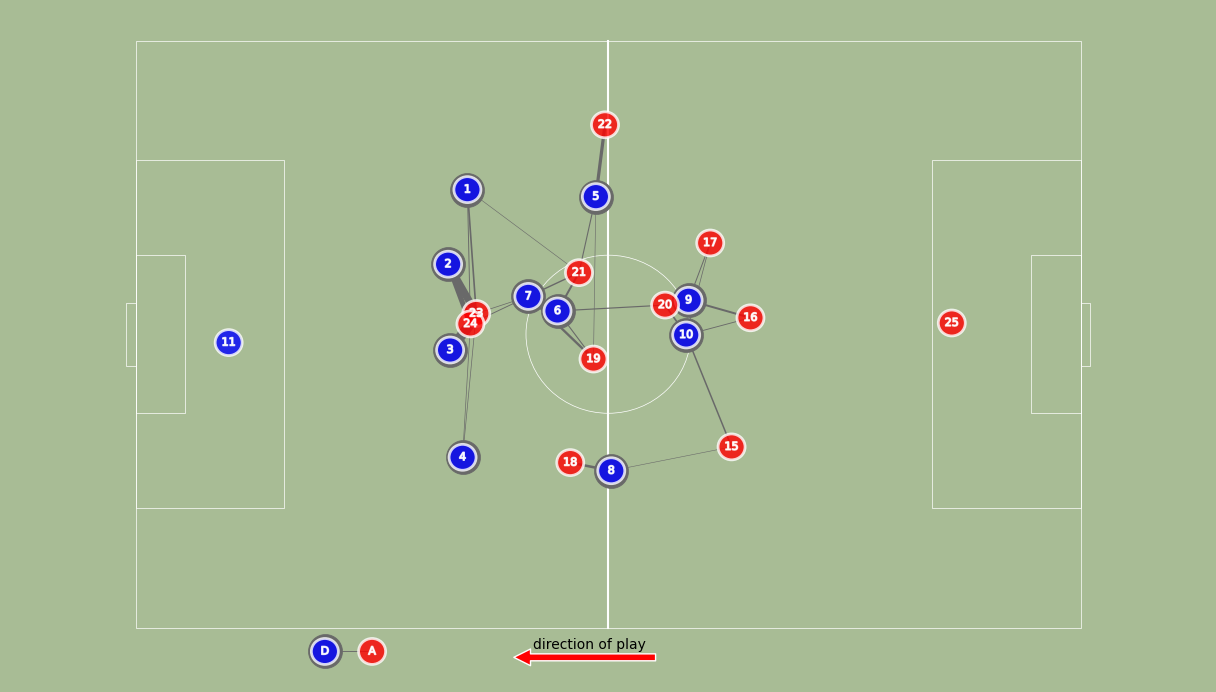

In [11]:
fig, ax = draw_marking_map(dfMarkPoss, dfHomePoss, dfAwayPoss)

## Blue Team Attacking

In [12]:
%%time
dfHomePoss, dfAwayPoss = get_possession_dfs('Home', dfHome, dfAway, dfEvents)
dfHomePoss = dfHomePoss[dfHomePoss.player!='Player12']

dfMarkPoss = get_marking_all(dfHomePoss.reset_index(), dfAwayPoss.reset_index(), max_dist=7.5)
get_marking_table(dfMarkPoss)

Wall time: 14.7 s


defender,None,Player15,Player16,Player17,Player18,Player19,Player20,Player21,Player22,Player23,Player24,Player25
attacker,,,,,,,,,,,,
None,0%,41%,35%,32%,47%,37%,24%,25%,31%,19%,27%,97%
Player1,31%,2%,4%,2%,3%,6%,2%,10%,12%,6%,1%,0%
Player10,35%,21%,9%,14%,5%,6%,20%,3%,5%,2%,1%,0%
Player11,99%,0%,0%,0%,0%,0%,0%,0%,0%,1%,0%,0%
Player2,56%,0%,2%,0%,1%,1%,1%,5%,3%,23%,13%,0%
Player3,47%,3%,3%,2%,1%,3%,2%,3%,1%,13%,35%,0%
Player4,76%,1%,0%,2%,8%,6%,1%,2%,0%,5%,3%,0%
Player5,45%,1%,2%,7%,2%,5%,8%,5%,34%,3%,1%,0%
Player6,36%,1%,4%,2%,1%,14%,9%,21%,3%,16%,11%,0%


(<Figure size 1280x760 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2c003878d48>)

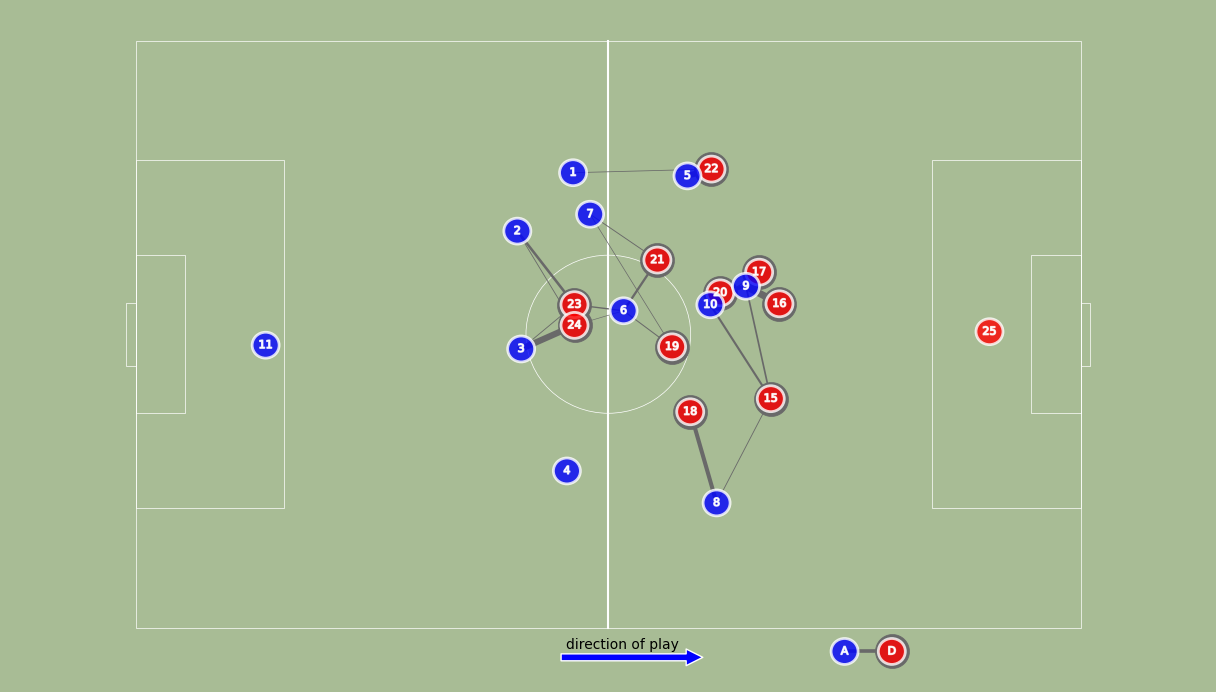

In [13]:
draw_marking_map(dfMarkPoss, dfAwayPoss, dfHomePoss, att_color='blue', def_color='red')

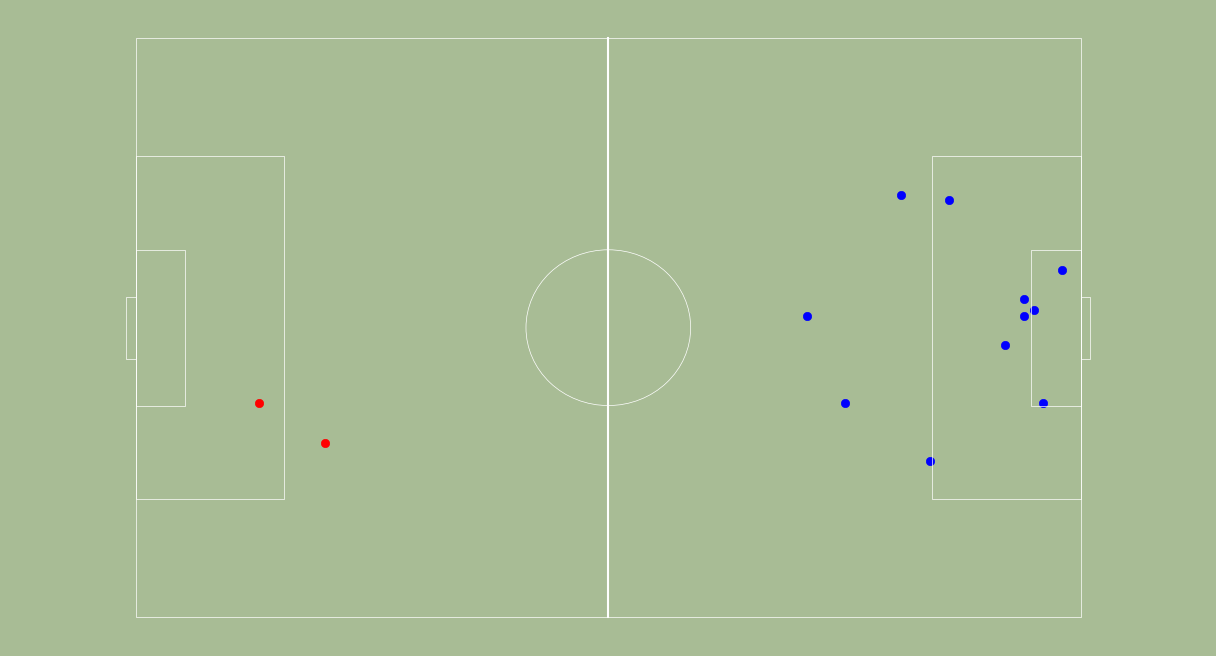

In [14]:
fig,ax = footyviz.draw_pitch()
for team, color in (('Home', 'blue'), ('Away', 'red')):
    plt.scatter(data=dfEvents[(dfEvents.Type=='SHOT')&(dfEvents.Team==team)]*100, x='Start X', y='Start Y', c=color)

In [15]:
dfEvents[dfEvents.Type=='SHOT']

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Possession_ID
34,Home,SHOT,HEAD-ON TARGET-GOAL,1,2289,91.56,2309,92.36,Player9,NaN,0.92,0.47,1.01,0.55,8
79,Home,SHOT,OFF TARGET-OUT,1,5923,236.92,5953,238.12,Player10,NaN,0.84,0.27,1.04,0.60,24
110,Away,SHOT,OFF TARGET-OUT,1,7753,310.12,7789,311.56,Player21,NaN,0.20,0.30,-0.04,0.65,37
135,Home,SHOT,ON TARGET-SAVED,1,9628,385.12,9632,385.28,Player8,NaN,0.96,0.37,0.98,0.46,46
239,Home,SHOT,HEAD-OFF TARGET-OUT,1,18270,730.80,18301,732.04,Player8,NaN,0.94,0.55,1.03,0.61,80
254,Away,SHOT,ON TARGET-SAVED,1,19470,778.80,19483,779.32,Player24,NaN,0.13,0.37,0.02,0.48,83
362,Home,SHOT,HEAD-OFF TARGET-OUT,1,26608,1064.32,26636,1065.44,Player8,NaN,0.95,0.53,1.03,0.47,112
425,Home,SHOT,OFF TARGET-OUT,1,31190,1247.60,31235,1249.40,Player7,NaN,0.75,0.37,1.05,0.59,126
662,Home,SHOT,HEAD-ON TARGET-SAVED,1,53695,2147.80,53707,2148.28,Player8,NaN,0.94,0.52,1.00,0.54,196
667,Home,SHOT,BLOCKED,1,53775,2151.00,53775,2151.00,Player5,NaN,0.86,0.72,0.89,0.73,198


(<Figure size 1280x760 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2c0024c6148>)

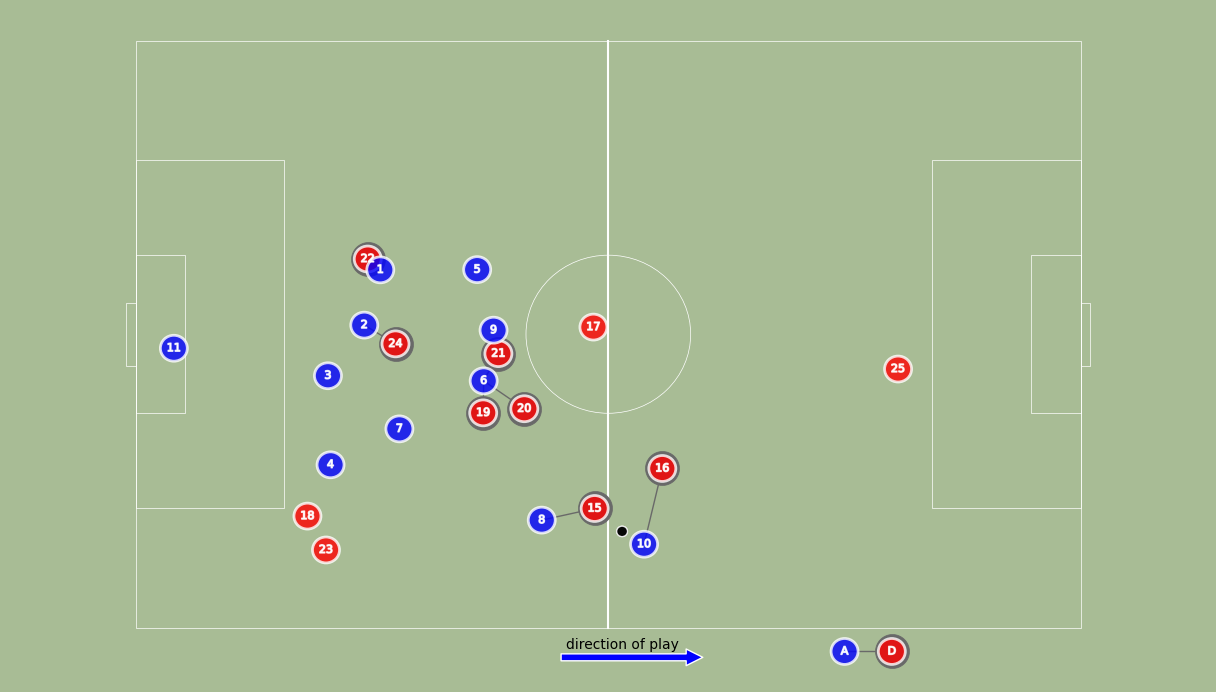

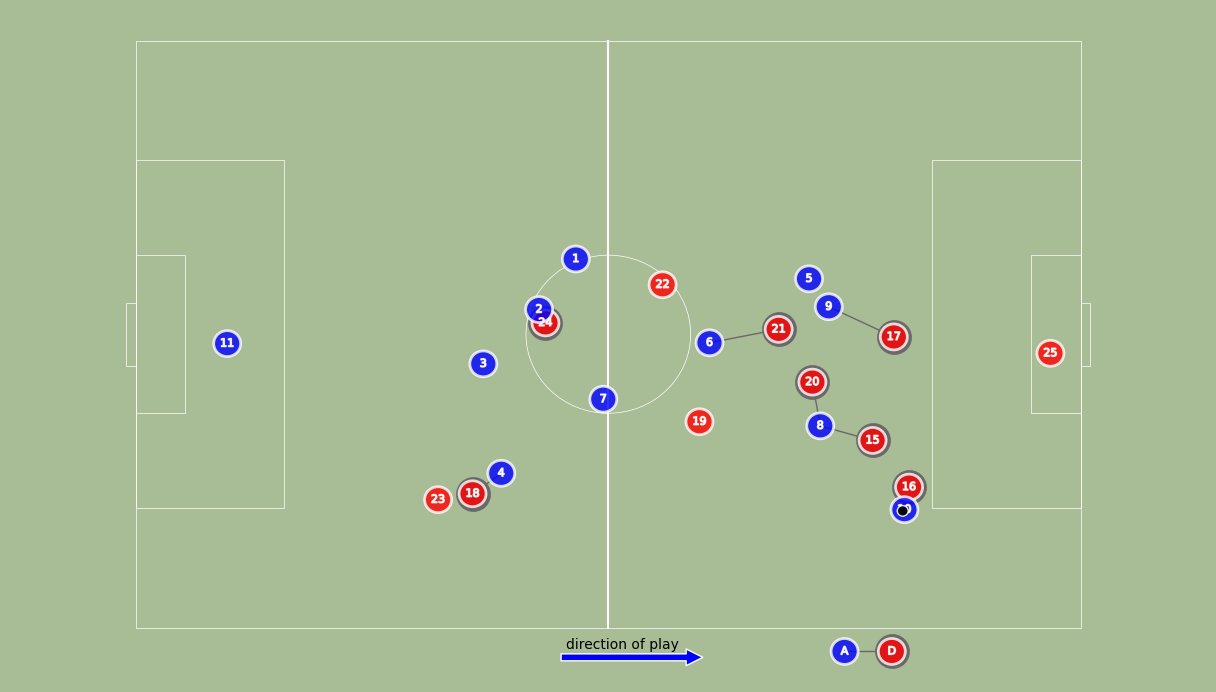

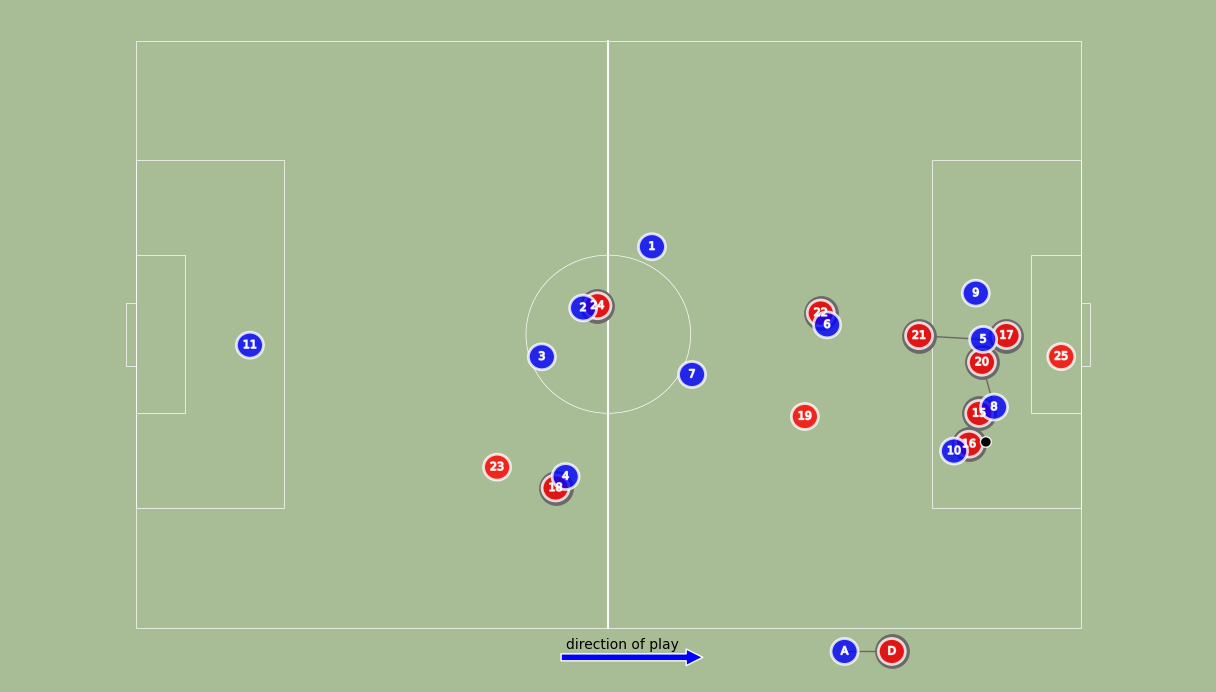

In [16]:
#moments before Home team's third shot
draw_marking_map(dfMarkPoss, dfAwayPoss, dfHomePoss, frame=9435, drop_ball=False, att_color='blue', def_color='red')
draw_marking_map(dfMarkPoss, dfAwayPoss, dfHomePoss, frame=9550, drop_ball=False, att_color='blue', def_color='red')
draw_marking_map(dfMarkPoss, dfAwayPoss, dfHomePoss, frame=9610, drop_ball=False, att_color='blue', def_color='red')

(<Figure size 1280x760 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2c002161908>)

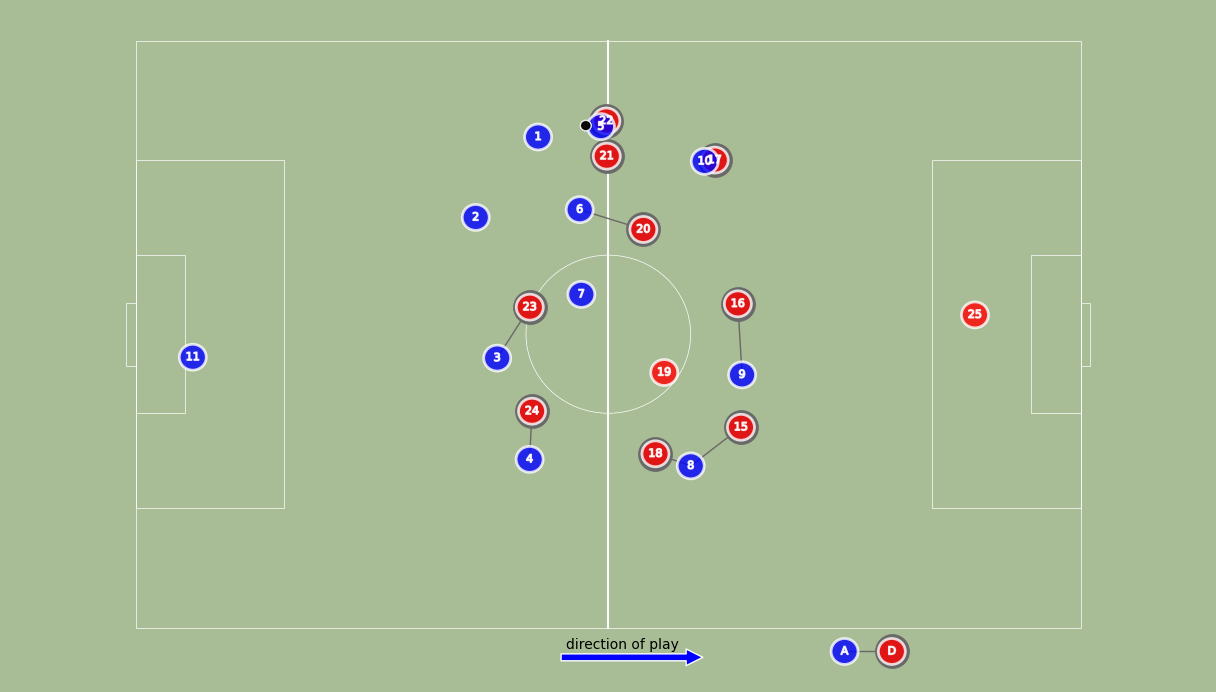

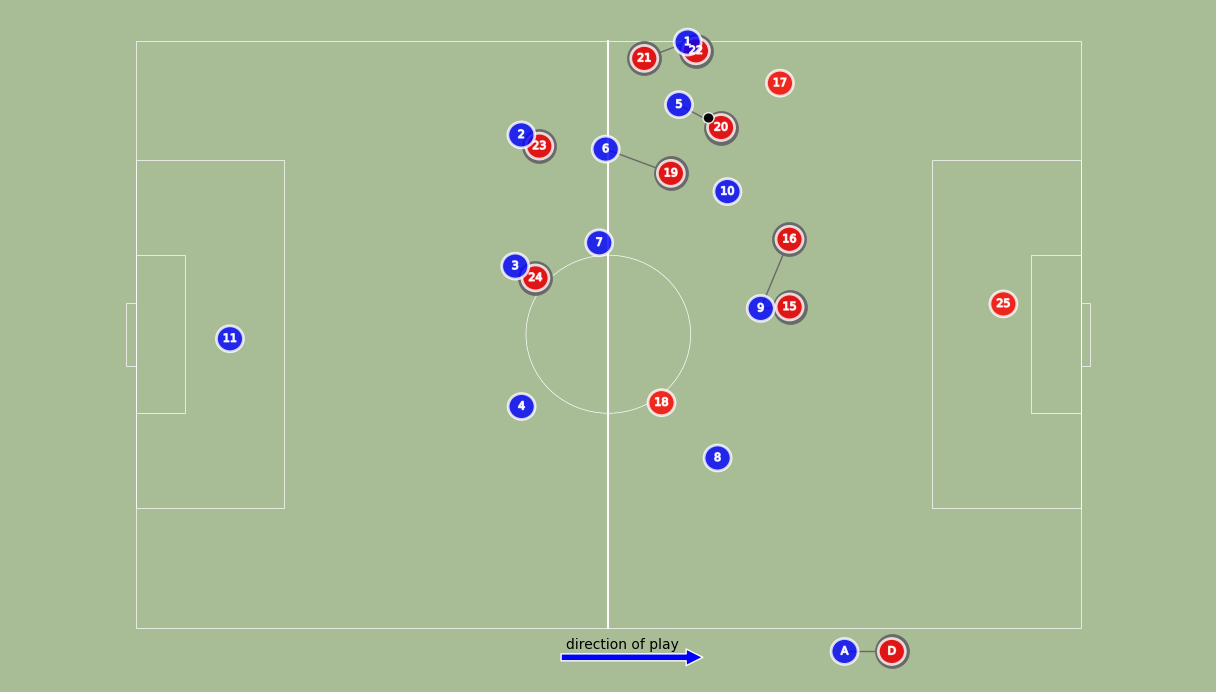

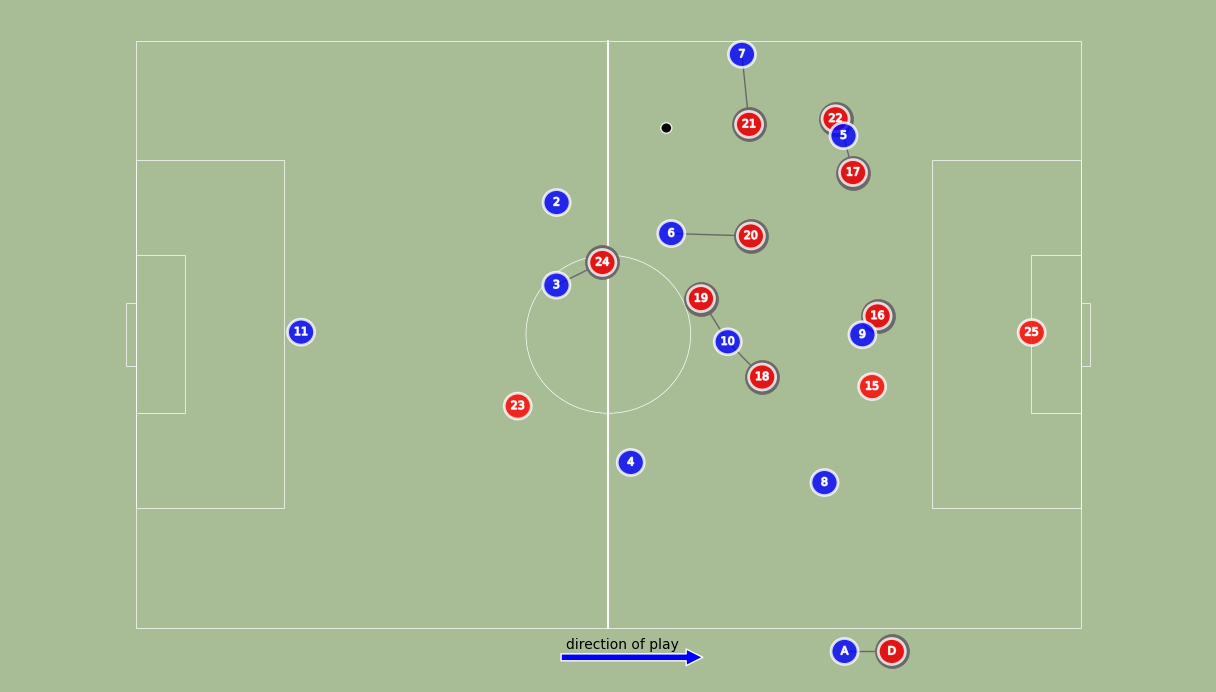

In [17]:
draw_marking_map(dfMarkPoss, dfAwayPoss, dfHomePoss, frame=dfAwayPoss.sample().index[0], drop_ball=False, att_color='blue', def_color='red')
draw_marking_map(dfMarkPoss, dfAwayPoss, dfHomePoss, frame=dfAwayPoss.sample().index[0], drop_ball=False, att_color='blue', def_color='red')
draw_marking_map(dfMarkPoss, dfAwayPoss, dfHomePoss, frame=dfAwayPoss.sample().index[0], drop_ball=False, att_color='blue', def_color='red')